### Part 3 – Individual Athlete Visualization  
**Contributor:** Jonathan Jafari  
**Athlete:** PLAYER_680  
**Metric:** Jump Height (m)  
**Figure file:** `screenshots/part3_player680_line_plot.png`

In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd


load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_TABLE = os.getenv("DB_TABLE")

connection_string = (
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

engine = create_engine(connection_string)

df = pd.read_sql(text(f"SELECT * FROM {DB_TABLE} LIMIT 50000"), engine)
df.head()


In [ ]:
# List most common metrics to help select one
metric_counts = df["metric"].value_counts().head(40)
metric_counts


In [ ]:
# Replace with the chosen metric name from metric_counts output
metric_of_interest = "Jump Height(m)"

players_with_metric = (
    df[df["metric"] == metric_of_interest]["playername"]
    .value_counts()
    .head(20)
)

players_with_metric


In [ ]:
player_of_interest = "PLAYER_680"
metric_of_interest = "Jump Height(m)"

subset = df[
    (df["playername"] == player_of_interest) &
    (df["metric"] == metric_of_interest)
].copy()

subset = subset.sort_values("timestamp")

subset.head()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.plot(subset["timestamp"], subset["value"], marker='o')
plt.xlabel("Date")
plt.ylabel(metric_of_interest)
plt.title(f"{metric_of_interest} Over Time for {player_of_interest}")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("screenshots/part3_player680_line_plot.png", dpi=300)
plt.show()



# Xiao's Version 3.1 Individual Athlete Timeline (Pair Work)

In [1]:
%pip install scipy
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_TABLE = os.getenv("DB_TABLE")

connection_string = (
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

engine = create_engine(connection_string)

print("Database connection established successfully.")

df = pd.read_sql(text(f"SELECT * FROM {DB_TABLE}"), engine)
print("Data retrieved successfully.\n")
df.head()


selected_metrics = [
    "Jump Height(m)",
    "Peak Propulsive Force(N)",
    "Peak Velocity(m/s)",
    "Propulsive Net Impulse(N.s)",
    "mRSI",
]


Note: you may need to restart the kernel to use updated packages.
Database connection established successfully.
Data retrieved successfully.



In [2]:
# filter teams based on coverage of selected metrics
metrics_sql = ", ".join([f"'{m}'" for m in selected_metrics])

query_team_coverage = f"""
SELECT 
    team,
    COUNT(DISTINCT metric) AS num_metrics_found
FROM {DB_TABLE}
WHERE metric IN ({metrics_sql})
GROUP BY team
ORDER BY num_metrics_found DESC;
"""

team_coverage = pd.read_sql(text(query_team_coverage), engine)
team_coverage

,team,num_metrics_found
0,Team: Old Football,5
1,Team: Stony Brook Men's Soccer,5
2,"Team: Stony Brook Men's Basketball , Team: Men...",5
3,Team: Stony Brook Men's Basketball,5
4,"Team: Stony Brook Football, Team: Stony Brook",5
...,...,...
67,"Group: Football Bigs, Team: Stony Brook Football",5
68,"Group: Football Big Skill, Team: Stony Brook, ...",5
69,"Group: Football Big Skill, Team: Stony Brook F...",5
70,"Group: 2023-2024 WBB, Group: Women's Basketbal...",5


In [3]:
# Filter players who have all 5 selected metrics from the chosen team
chosen_team = "Team: Stony Brook Men's Basketball".replace("'","''")
query_playersallmetrics = f"""
SELECT
    playername,
    COUNT(DISTINCT metric) AS num_metrics,team
FROM {DB_TABLE}
WHERE team = '{chosen_team}'
  AND metric IN ({metrics_sql})
GROUP BY playername
HAVING num_metrics = {len(selected_metrics)}
ORDER BY team
"""

df_playersallmetrics = pd.read_sql(text(query_playersallmetrics), engine)
df_playersallmetrics

,playername,num_metrics,team
0,PLAYER_002,5,Team: Stony Brook Men's Basketball
1,PLAYER_074,5,Team: Stony Brook Men's Basketball
2,PLAYER_1036,5,Team: Stony Brook Men's Basketball
3,PLAYER_1050,5,Team: Stony Brook Men's Basketball
4,PLAYER_1188,5,Team: Stony Brook Men's Basketball
5,PLAYER_1282,5,Team: Stony Brook Men's Basketball
6,PLAYER_1283,5,Team: Stony Brook Men's Basketball
7,PLAYER_1285,5,Team: Stony Brook Men's Basketball
8,PLAYER_243,5,Team: Stony Brook Men's Basketball
9,PLAYER_324,5,Team: Stony Brook Men's Basketball


In [4]:
# PLAYER_999 and PLAYER_404 has been chosen for our metrics
# create my main database and clean up types on data for plotting function
player_list = ["PLAYER_999", "PLAYER_404"]
player_sql = ", ".join([f"'{p.replace("'", "''")}'" for p in player_list])

query_team_metrics = f"""
SELECT * 
FROM {DB_TABLE}
WHERE team = '{chosen_team}'
AND playername IN ({player_sql})
AND metric IN ({metrics_sql});
"""
df_team = pd.read_sql(text(query_team_metrics),engine)

df_team["timestamp"] = pd.to_datetime(df_team['timestamp'])
df_team["value"] = pd.to_numeric(df_team['value'], errors ='coerce')

print(df_team.shape)
df_team.head()

(620, 12)


,id,playername,timestamp,device,metric,value,team,session_type,session_description,function_description,data_source,created_at
0,5868614,PLAYER_404,2025-06-23 14:19:39,hawkins,Jump Height(m),0.4595,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
1,5868643,PLAYER_404,2025-06-23 14:19:39,hawkins,Peak Propulsive Force(N),2355.0000,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
2,5868649,PLAYER_404,2025-06-23 14:19:39,hawkins,Peak Velocity(m/s),3.0826,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
3,5868653,PLAYER_404,2025-06-23 14:19:39,hawkins,Propulsive Net Impulse(N.s),253.5380,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10
4,5868676,PLAYER_404,2025-06-23 14:19:39,hawkins,mRSI,0.6418,Team: Stony Brook Men's Basketball,None,None,None,hawkins,2025-10-21 17:01:10


In [9]:
def plot_athlete_metrics(df_team, athlete, selected_metrics, months_back=12):
    df_a = df_team[df_team["playername"] == athlete].copy()
    if df_a.empty:
        print(f"No data found for {athlete}.")
        return pd.DataFrame()

    # Sort chronologically
    df_a = df_a.sort_values("timestamp")

    # Restrict to last 12 months
    max_date = df_a["timestamp"].max()
    min_date = max_date - pd.DateOffset(months=months_back)
    df_a = df_a[df_a["timestamp"] >= min_date]

    print(f"\n===== Athlete: {athlete} =====")
    print(f"Date range: {df_a['timestamp'].min()} → {df_a['timestamp'].max()}")
    print(f"Rows: {df_a.shape[0]}")

    summary_rows = []

    for metric in selected_metrics:

        temp = df_a[df_a["metric"] == metric].copy()
        if temp.empty:
            print(f"  - {metric}: no data available, skipping.")
            continue

        # Plot
        plt.figure(figsize=(10, 4))
        plt.plot(temp["timestamp"], temp["value"], marker="o")
        plt.title(f"{metric} over time — {athlete}")
        plt.xlabel("Date")
        plt.ylabel(metric)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Best & worst performance
        best_idx = temp["value"].idxmax()
        worst_idx = temp["value"].idxmin()

        best_value = temp.loc[best_idx, "value"]
        best_date = temp.loc[best_idx, "timestamp"]

        worst_value = temp.loc[worst_idx, "value"]
        worst_date = temp.loc[worst_idx, "timestamp"]

        # Linear trend calculation
        temp["ts_num"] = temp["timestamp"].map(pd.Timestamp.toordinal)
        if len(temp) > 1:
            slope, intercept, r, p, stderr = linregress(temp["ts_num"], temp["value"])
        else:
            slope, intercept, r, p, stderr = (0, 0, 0, 1, 0)

        summary_rows.append([
            metric,
            best_value, best_date,
            worst_value, worst_date,
            slope, r, p
        ])

    summary_df = pd.DataFrame(
        summary_rows,
        columns=[
            "Metric",
            "Best Value", "Best Date",
            "Worst Value", "Worst Date",
            "Trend Slope", "R", "p_value"
        ]
    )
    return summary_df


In [10]:
player_list = ["PLAYER_999", "PLAYER_404"]



===== Athlete: PLAYER_999 =====
Date range: 2023-07-06 18:10:48 → 2024-02-27 19:34:02
Rows: 465


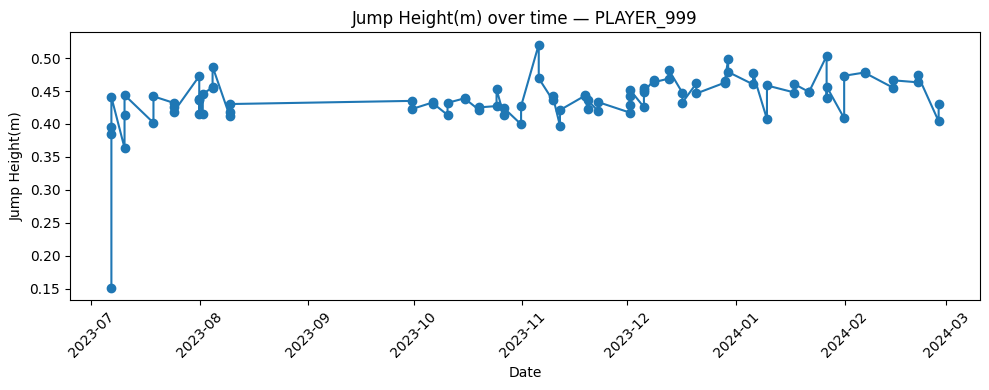

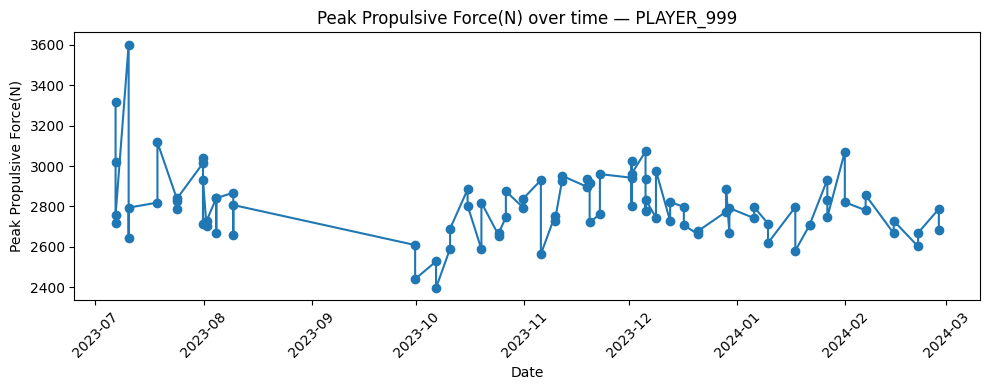

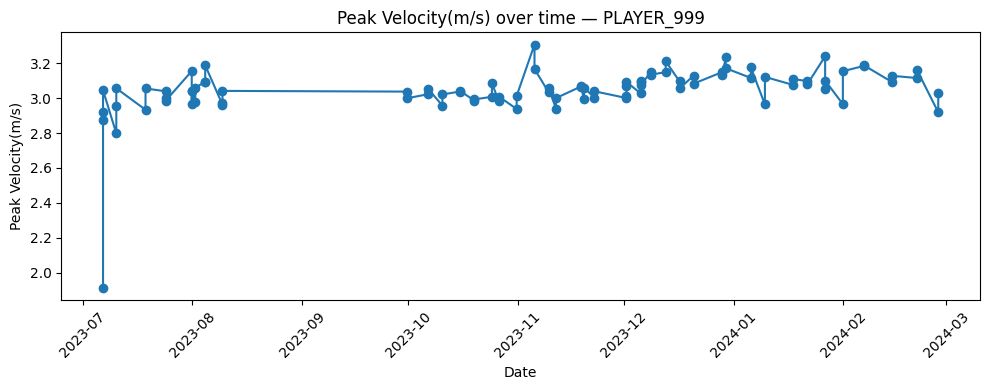

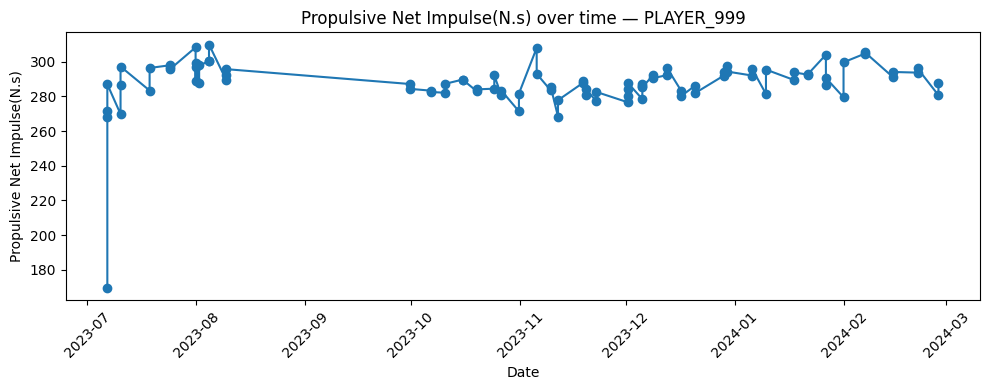

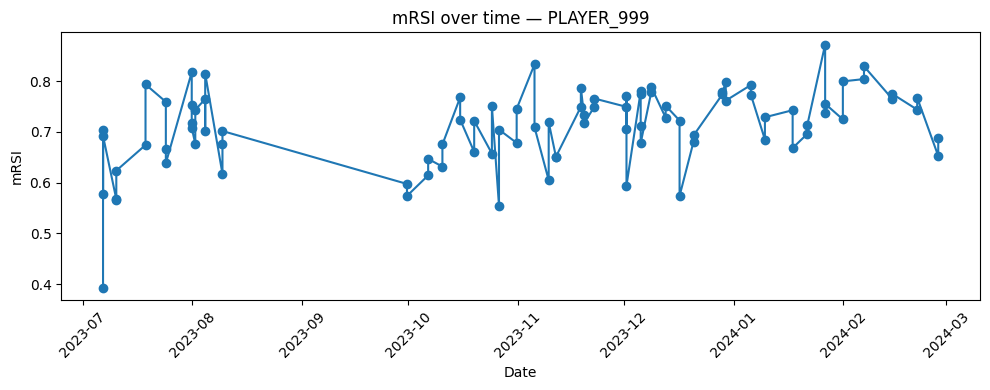

,Metric,Best Value,Best Date,Worst Value,Worst Date,Trend Slope,R,p_value
0,Jump Height(m),0.5207,2023-11-05 16:54:00,0.1511,2023-07-06 18:10:48,0.000233,0.412325,0.000040
1,Peak Propulsive Force(N),3601.0000,2023-07-10 12:11:57,2397.0000,2023-10-06 15:34:19,-0.498773,-0.209235,0.044131
2,Peak Velocity(m/s),3.3081,2023-11-05 16:54:00,1.9119,2023-07-06 18:10:48,0.000829,0.403524,0.000061
3,Propulsive Net Impulse(N.s),309.9197,2023-08-04 15:11:10,169.5575,2023-07-06 18:10:48,0.033644,0.158074,0.130196
4,mRSI,0.8721,2024-01-26 20:21:54,0.3927,2023-07-06 18:10:48,0.000413,0.385889,0.000133


In [11]:
summary_999 = plot_athlete_metrics(df_team, "PLAYER_999", selected_metrics, months_back=12)
summary_999



===== Athlete: PLAYER_404 =====
Date range: 2025-06-23 14:19:39 → 2025-10-13 22:28:25
Rows: 155


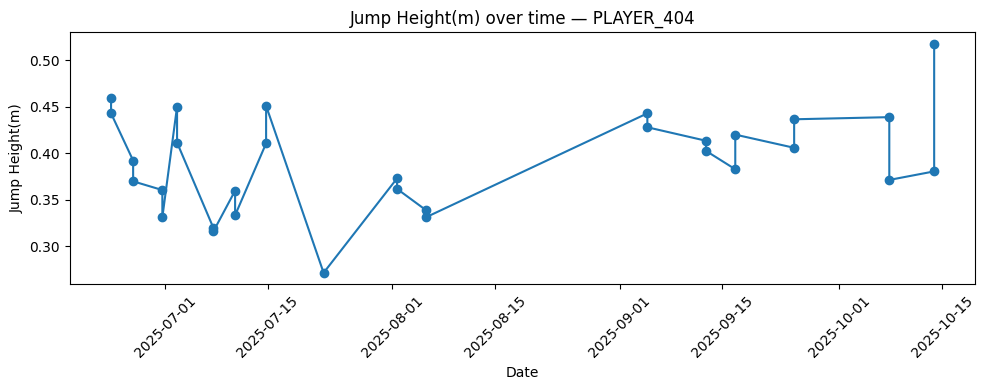

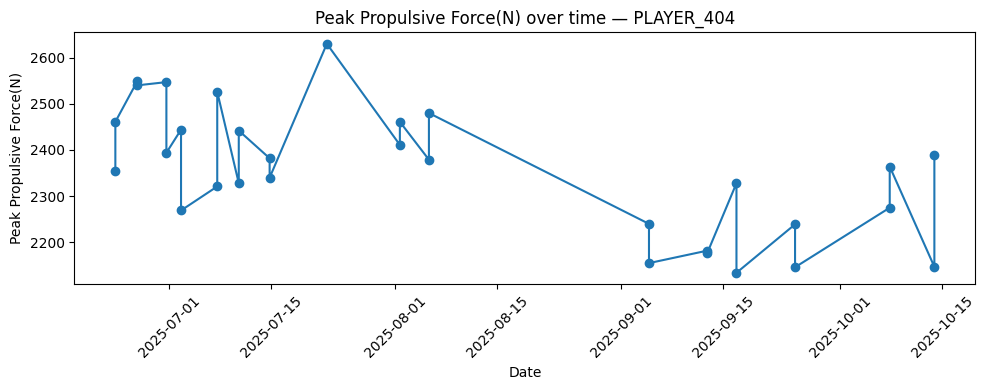

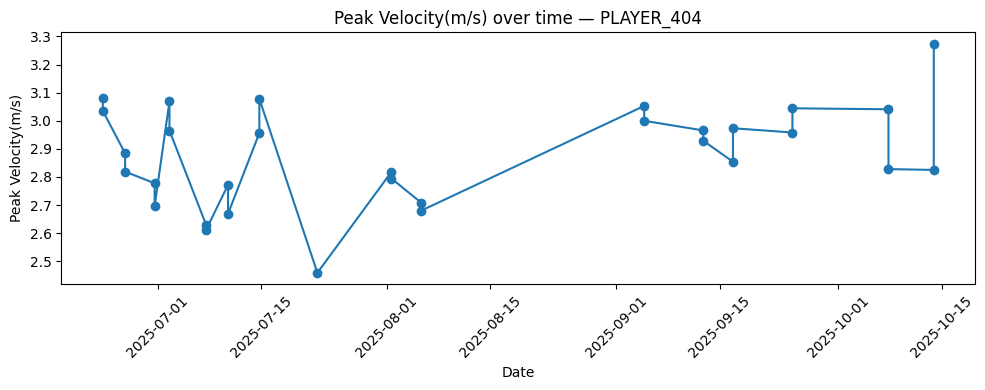

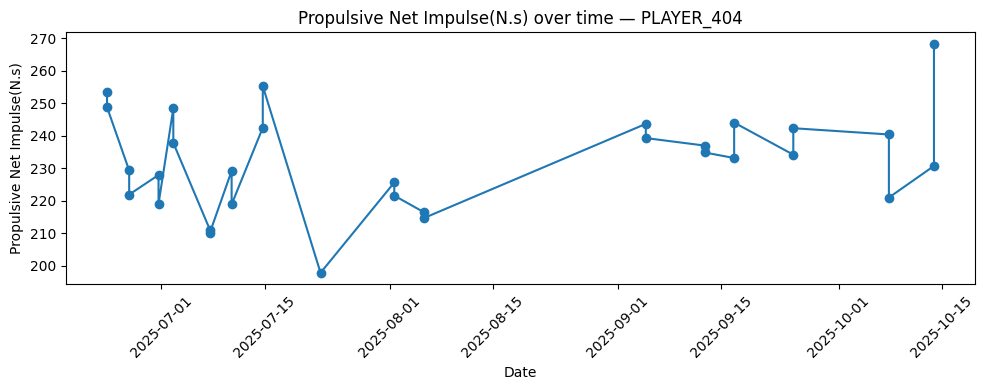

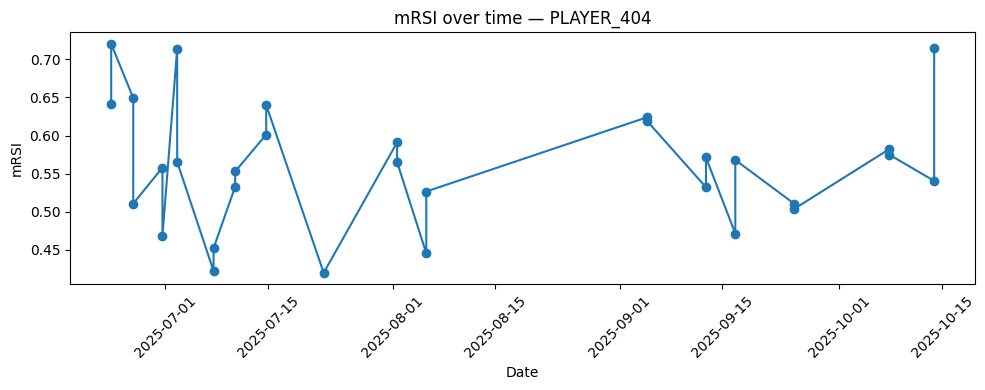

,Metric,Best Value,Best Date,Worst Value,Worst Date,Trend Slope,R,p_value
0,Jump Height(m),0.5179,2025-10-13 22:28:25,0.2713,2025-07-22 14:32:59,0.000442,0.328488,0.071196
1,Peak Propulsive Force(N),2630.0000,2025-07-22 14:32:59,2134.0000,2025-09-16 18:58:37,-2.252692,-0.651119,0.000073
2,Peak Velocity(m/s),3.2737,2025-10-13 22:28:25,2.4593,2025-07-22 14:32:59,0.001526,0.340501,0.060879
3,Propulsive Net Impulse(N.s),268.3646,2025-10-13 22:28:25,197.8147,2025-07-22 14:32:59,0.096051,0.248124,0.178341
4,mRSI,0.7204,2025-06-23 14:19:48,0.4198,2025-07-22 14:32:59,-0.000020,-0.009887,0.957900


In [12]:
summary_404 = plot_athlete_metrics(df_team, "PLAYER_404", selected_metrics, months_back=12)
summary_404


# 3.1 Individual Athlete Timeline (Pair Work)
## Contributor: Anthony Mapuyan 

In [ ]:
# Establish database connection and import libraries
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT", "3306")
DB_NAME = os.getenv("DB_NAME")
DB_TABLE = os.getenv("DB_TABLE", "research_experiment_refractor_test")

connection_string = (   
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

engine = create_engine(connection_string)

print("Database connection established successfully.")

In [ ]:
SELECTED_METRICS = [
    "Jump Height(m)",
    "Peak Propulsive Force(N)",
    "Peak Velocity(m/s)",
    "Propulsive Net Impulse(N.s)",
    "mRSI",
]
